In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

# Load the base model
base_model = EfficientNetB0(weights='imagenet', include_top=False)
base_model.trainable = False

# Preprocess the image
image_path = 'dog.jpeg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
img_tensor = tf.expand_dims(img_array, axis=0)  # Add batch dimension

# Pass the image tensor through the model
cnn_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)
output = cnn_model(img_tensor)

print(output.shape)


In [ ]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set Metal as the default compute device
# tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

# Load ResNet50 without top layers
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',  # Or specify None if you don't want to use pre-trained weights
    input_shape=(224, 224, 3)  # Adjust input shape according to your needs
)
resnet50.trainable = False  # Freeze the weights of the ResNet50 base model

# Define additional layers
output = resnet50.output
output = tf.keras.layers.Reshape((-1, 2048))(output)  # Reshape the output to match the desired shape
output = tf.keras.layers.Dense(1280)(output)  # Add a dense layer to reduce dimensionality


In [ ]:
# Create the model
cnn_model = tf.keras.Model(inputs=resnet50.input, outputs=output)

# Load and preprocess the image
image_path = 'dog.jpeg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Preprocess input for ResNet50

# Process the image through the model
features = cnn_model.predict(tf.expand_dims(img_array, axis=0))

print(features.shape)  # Check the shape of the extracted features


---

# coreml implementation

In [ ]:
import coremltools as ct

In [ ]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
import coremltools as ct
import numpy as np
import time
from PIL import Image

# Load the CoreML model
model = ct.models.MLModel('converted_model.mlpackage')

# Prepare input data (replace 'input_image.jpg' with your test image)
image = Image.open('cat.jpeg').resize((224, 224))
image = np.array(image) / 127.0 - 1.0
input_data = {'input_image': image}

# Perform inference and measure time
start_time = time.time()
output = model.predict(input_data)
inference_time = time.time() - start_time

# Print inference result
print("Inference result:", output)

# Print inference time
print("Inference time:", inference_time, "seconds")

In [ ]:
# Tested with TensorFlow 2.6.2
import tensorflow as tf
import coremltools as ct

tf_keras_model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ]
)

# Pass in `tf.keras.Model` to the Unified Conversion API
mlmodel = ct.convert(tf_keras_model, convert_to="mlprogram", source="tensorflow")

# or save the keras model in SavedModel directory format and then convert
tf_keras_model.save('tf_keras_model')
mlmodel = ct.convert('tf_keras_model', convert_to="mlprogram")

# or load the model from a SavedModel and then convert
tf_keras_model = tf.keras.models.load_model('tf_keras_model')
mlmodel = ct.convert(tf_keras_model, convert_to="mlprogram")

# or save the keras model in HDF5 format and then convert
tf_keras_model.save('tf_keras_model.h5')
mlmodel = ct.convert('tf_keras_model.h5', convert_to="mlprogram")

In [ ]:
!pip install coremltools

In [ ]:
import coremltools as ct

saved_model_path = 'saved_model/'
tf.saved_model.save(cnn_model, saved_model_path)

# Convert the TensorFlow SavedModel to CoreML
model = ct.convert(saved_model_path)

model.save('converted_model.mlpackage')

In [ ]:
import tensorflow as tf

inputs = tf.constant([[1, 2, 0], [3, 0, 0], [4, 5, 6]])
tf.math.not_equal(inputs, 0)

---

In [1]:
from tensorflow.keras.applications import efficientnet as efn
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [2]:
anns_file_path = 'coco/annotations/instances_val2017.json'
images_dir = 'coco/images/val2017'

In [3]:
# open annotations file
with open(anns_file_path, 'r') as f:
    anns = json.loads(f.read())

In [4]:
# Load the annotations into a DataFrame
anns_df = pd.DataFrame(anns['annotations'])
anns_df.drop_duplicates(subset=['image_id'], inplace=True)
anns_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,"[[510.66, 423.01, 511.72, 420.03, 510.45, 416....",702.10575,0,289343,"[473.07, 395.93, 38.65, 28.67]",18,1768
1,"[[289.74, 443.39, 302.29, 445.32, 308.09, 427....",27718.47630,0,61471,"[272.1, 200.23, 151.97, 279.77]",18,1773
2,"[[147.76, 396.11, 158.48, 355.91, 153.12, 347....",78969.31690,0,472375,"[124.71, 196.18, 372.85, 356.81]",18,2551
3,"[[260.4, 231.26, 215.06, 274.01, 194.33, 307.6...",108316.66515,0,520301,"[112.71, 154.82, 367.29, 479.35]",18,3186
4,"[[200.61, 253.97, 273.19, 318.49, 302.43, 336....",75864.53530,0,579321,"[200.61, 89.65, 400.22, 251.02]",18,3419


In [5]:
len(anns_df)

4952

In [6]:
def add_zeros_and_extension(image_ids):
    # Convert image_ids to strings and add '.jpg' extension
    image_paths = [f'{str(image_id).zfill(12)}.jpg' for image_id in image_ids]
    return image_paths

anns_df['file_name'] = add_zeros_and_extension(anns_df['image_id'])
anns_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id,file_name
0,"[[510.66, 423.01, 511.72, 420.03, 510.45, 416....",702.10575,0,289343,"[473.07, 395.93, 38.65, 28.67]",18,1768,000000289343.jpg
1,"[[289.74, 443.39, 302.29, 445.32, 308.09, 427....",27718.47630,0,61471,"[272.1, 200.23, 151.97, 279.77]",18,1773,000000061471.jpg
2,"[[147.76, 396.11, 158.48, 355.91, 153.12, 347....",78969.31690,0,472375,"[124.71, 196.18, 372.85, 356.81]",18,2551,000000472375.jpg
3,"[[260.4, 231.26, 215.06, 274.01, 194.33, 307.6...",108316.66515,0,520301,"[112.71, 154.82, 367.29, 479.35]",18,3186,000000520301.jpg
4,"[[200.61, 253.97, 273.19, 318.49, 302.43, 336....",75864.53530,0,579321,"[200.61, 89.65, 400.22, 251.02]",18,3419,000000579321.jpg


In [7]:
anns_df['file_name'] = anns_df['file_name'].astype(str)

In [8]:
!pwd

/Users/thilakcm/Downloads/UMD stuff/spring 2024/NLP/project/NLP641FinalProject


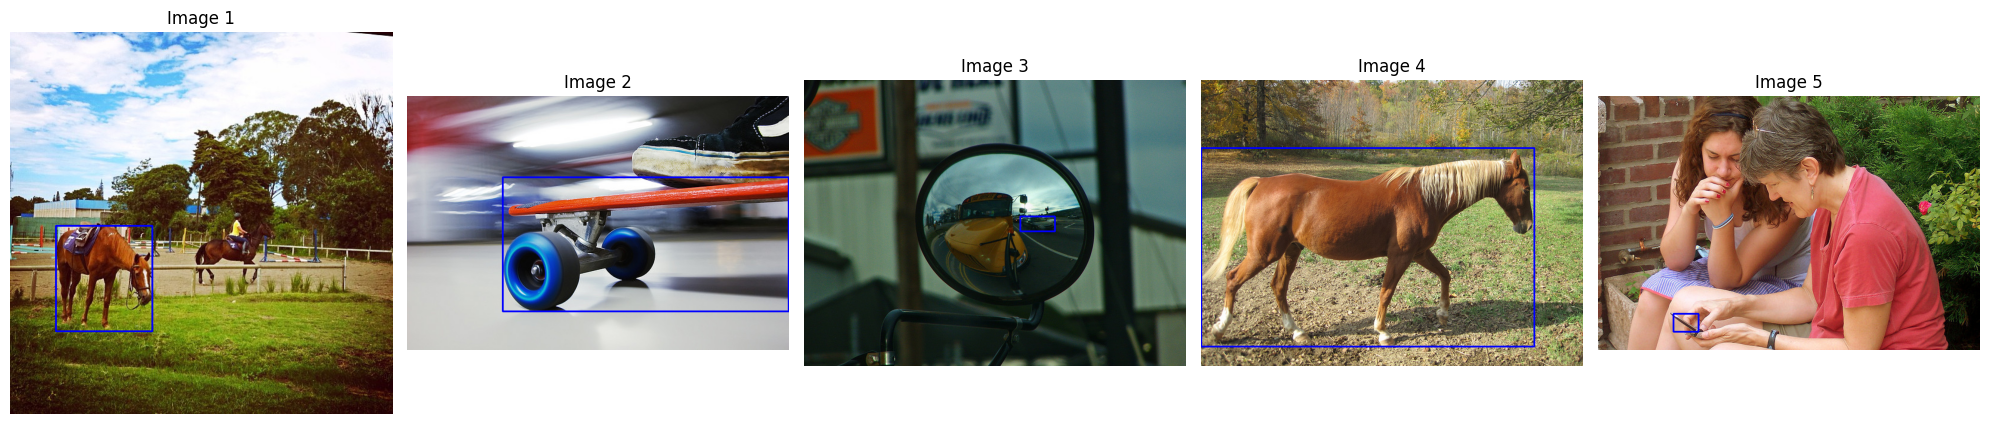

In [9]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Define the directory containing images
images_dir = "coco/images/val2017"

# Function to draw bounding boxes and display images
def draw_bounding_boxes(image_ids, anns_df, images_dir, num_images=5):
    # Select 5 random image IDs
    random_image_ids = random.sample(list(image_ids), num_images)
    
    # Create a subplot with 5 rows
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 6))

    # Iterate over the selected random image IDs
    for i, image_id in enumerate(random_image_ids):
        # Load the image
        image_path = os.path.join(images_dir, image_id)
        image = cv2.imread(image_path)

        # Get the bounding box coordinates
        bbox = anns_df.loc[anns_df['file_name'] == image_id, 'bbox'].values[0]
        bbox = [int(coord) for coord in bbox]
        x, y, w, h = bbox

        # Draw the bounding box on the image
        image_with_bbox = cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Display the image with bounding box
        axes[i].imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

# Call the function to draw bounding boxes for 5 random images
draw_bounding_boxes(anns_df['file_name'], anns_df, images_dir, num_images=5)


In [11]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split

IMAGE_SIZE = (299, 299)
batch_size = 64
input_shape = (299, 299)

# Define data generators
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, input_shape[:2])
    image = preprocess_input(image) 
    return image, label

# Convert image paths to strings
anns_df['file_name'] = anns_df['file_name'].astype(str)

# Perform train-test split
train_df, val_df = train_test_split(anns_df, test_size=0.1, random_state=42)

# Convert image paths to strings
train_df['file_name'] = train_df['file_name'].astype(str)
val_df['file_name'] = val_df['file_name'].astype(str)

# Define train and validation datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df['file_name'], train_df['category_id']))
train_ds = train_ds.map(preprocess_image).batch(batch_size)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['file_name'], val_df['category_id']))
val_ds = val_ds.map(preprocess_image).batch(batch_size)

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import Huber

def get_cnn_model():
    # Load pre-trained EfficientNetB0 model
    base_model = EfficientNetB0(
        input_shape=(*input_shape, 3), include_top=False, weights="imagenet")
    
    # Freeze feature extractor layers
    base_model.trainable = False
    
    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[-10:]:
        layer.trainable = True
    
    # Reshape the output to match the desired shape
    base_model_out = layers.Reshape((-1, 1280))(base_model.output)
    
    # Define the model
    cnn_model = models.Model(base_model.input, base_model_out)
    return cnn_model


# Get the CNN model
cnn_model = get_cnn_model()

# Compile the model with Smooth L1 Loss
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss=Huber(),
                  metrics=['accuracy'])

# Train the model on your dataset
history = cnn_model.fit(train_ds,
                        epochs=10,
                        validation_data=val_ds)

# Save the model
cnn_model.save('fine_tuned_efficientnet.h5')

2024-05-11 11:50:40.787060: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-11 11:50:40.787090: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-11 11:50:40.787093: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-11 11:50:40.787718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-11 11:50:40.787753: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2024-05-11 11:50:44.821118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-11 11:50:48.000927: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: 000000563603.jpg; No such file or directory
2024-05-11 11:50:48.000979: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: 000000431140.jpg; No such file or directory
2024-05-11 11:50:48.000993: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: 000000226984.jpg; No such file or directory
2024-05-11 11:50:48.001005: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: 000000365655.jpg; No such file or directory
2024-05-11 11:50:48.001011: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:1

NotFoundError: Graph execution error:

Detected at node ReadFile defined at (most recent call last):
<stack traces unavailable>
Detected at node ReadFile defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) NOT_FOUND:  000000296222.jpg; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
	 [[StatefulPartitionedCall/adam/add_16/_84]]
  (1) NOT_FOUND:  000000296222.jpg; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_17317]

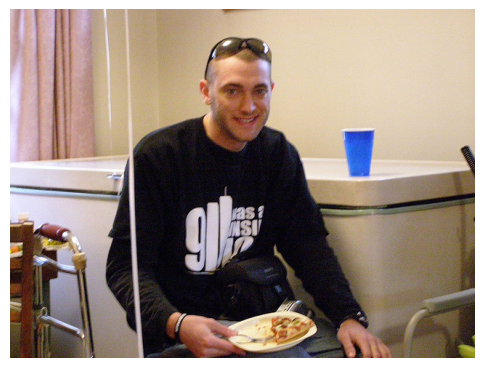

In [12]:
# show this image 000000296222.jpg
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'coco/images/val2017/000000296222.jpg'
image = cv2.imread(image_path)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import Huber
from tensorflow.keras.applications import EfficientNetB0
import cv2
import os
from sklearn.model_selection import train_test_split

# Define image directory
image_dir = "coco/images/val2017"

train_df, val_df = train_test_split(anns_df, test_size=0.1, random_state=42)

# Select a subset of 15 training images and 5 validation images
train_image_ids = train_df['file_name'].iloc[:40]
val_image_ids = val_df['file_name'].iloc[:30]

# Load and preprocess training images and labels
train_images = []
train_labels = train_df['category_id'].iloc[:40]  # Assuming category_id is the label
for image_id in train_image_ids:
    image_path = os.path.join(image_dir, image_id)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (299, 299))  # Resize to match input shape
    image = tf.keras.applications.efficientnet.preprocess_input(image)  # Preprocess input for EfficientNet
    train_images.append(image)
train_images = tf.convert_to_tensor(train_images)
train_labels = tf.convert_to_tensor(train_labels)

# Load and preprocess validation images and labels
val_images = []
val_labels = val_df['category_id'].iloc[:30]  # Assuming category_id is the label
for image_id in val_image_ids:
    image_path = os.path.join(image_dir, image_id)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (299, 299))  # Resize to match input shape
    image = tf.keras.applications.efficientnet.preprocess_input(image)  # Preprocess input for EfficientNet
    val_images.append(image)
val_images = tf.convert_to_tensor(val_images)
val_labels = tf.convert_to_tensor(val_labels)

def get_cnn_model():
    # Load pre-trained EfficientNetB0 model
    base_model = EfficientNetB0(
        input_shape=(299, 299, 3), include_top=False, weights="imagenet")
    
    # Freeze feature extractor layers
    base_model.trainable = False
    
    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[-10:]:
        layer.trainable = True
    
    # Add a global average pooling layer
    x = layers.GlobalAveragePooling2D()(base_model.output)
    
    # Add a dense layer with appropriate units
    x = layers.Dense(128, activation='relu')(x)
    
    # Add the output layer
    output = layers.Dense(1)(x)
    
    # Define the model
    cnn_model = models.Model(base_model.input, output)
    return cnn_model


# Get the CNN model
cnn_model = get_cnn_model()

# Compile the model
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss=Huber(),
                  metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

# Evaluate the model on the validation set
val_loss, val_accuracy = cnn_model.evaluate(val_images, val_labels)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 10s/step - accuracy: 0.0000e+00 - loss: 29.7047 - val_accuracy: 0.0000e+00 - val_loss: 27.2588
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.0000e+00 - loss: 29.1474 - val_accuracy: 0.0000e+00 - val_loss: 27.0194
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.0000e+00 - loss: 28.6792 - val_accuracy: 0.0333 - val_loss: 26.7909
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0333 - loss: 29.3738 - val_accuracy: 0.1000 - val_loss: 26.5772
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0437 - loss: 27.4148 - val_accuracy: 0.1000 - val_loss: 26.3702
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 913ms/step - accuracy: 0.0813 - loss: 26.8059 - val_accuracy: 0.1000 - val_loss: 26.1681
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0604 - loss: 28.8253 - val_accuracy: 0.1333 - val_loss: 25.9680
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 5s/step - accuracy: 0.1354 - loss: 27.3361 - val_accuracy: 

In [31]:
cnn_model.save('fine_tuned_efficientnet.keras')

In [33]:
# Load the model
model = tf.keras.models.load_model('fine_tuned_efficientnet.keras')

/Users/thilakcm/anaconda3/envs/ML-AI/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[<Conv2D name=block7a_project_conv, built=True>,
 <BatchNormalization name=block7a_project_bn, built=True>,
 <Conv2D name=top_conv, built=True>,
 <BatchNormalization name=top_bn, built=True>,
 <Activation name=top_activation, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [42]:
model.layers[-8:]

[<Conv2D name=block7a_project_conv, built=True>,
 <BatchNormalization name=block7a_project_bn, built=True>,
 <Conv2D name=top_conv, built=True>,
 <BatchNormalization name=top_bn, built=True>,
 <Activation name=top_activation, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [48]:
# model.summary()

In [45]:
model.get_layer('top_activation').output.reshape((-1, 1280))

<KerasTensor shape=(None, 1280), dtype=float32, sparse=False, name=keras_tensor_2685>

In [51]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model

# Reshape the output of 'top_activation'
reshaped_output = Reshape((-1, 1280))(model.get_layer('top_activation').output)

# Create a new model with the modified architecture
new_model = Model(inputs=model.input, outputs=reshaped_output)

# Verify the modified architecture
new_model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 299, 299,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 299, 299,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 299, 299,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 893,232 (3.41 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

In [52]:
# save new model
new_model.save('reshaped_finetuned_model.keras')

In [28]:
cnn_model.layers[-8:]

[<Conv2D name=block7a_project_conv, built=True>,
 <BatchNormalization name=block7a_project_bn, built=True>,
 <Conv2D name=top_conv, built=True>,
 <BatchNormalization name=top_bn, built=True>,
 <Activation name=top_activation, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

# image captioning cnn model summary

In [24]:
from tensorflow.keras.applications import efficientnet

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet")
    # Freeze feature extractor layers
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, 1280))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

# Get the CNN model
summary_cnn_model = get_cnn_model()

[<BatchNormalization name=block7a_project_bn, built=True>, <Conv2D name=top_conv, built=True>, <BatchNormalization name=top_bn, built=True>, <Activation name=top_activation, built=True>, <Reshape name=reshape_5, built=True>]


In [29]:
summary_cnn_model.layers[-8:]

[<Conv2D name=block7a_se_expand, built=True>,
 <Multiply name=block7a_se_excite, built=True>,
 <Conv2D name=block7a_project_conv, built=True>,
 <BatchNormalization name=block7a_project_bn, built=True>,
 <Conv2D name=top_conv, built=True>,
 <BatchNormalization name=top_bn, built=True>,
 <Activation name=top_activation, built=True>,
 <Reshape name=reshape_5, built=True>]

In [25]:
summary_cnn_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_12        │ (None, 299, 299,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_6     │ (None, 299, 299,  │          7 │ rescaling_12[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_13        │ (None, 299, 299,  │          0 │ normalization_6[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_13[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)